In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score

In [2]:
!wget "https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv"

--2021-04-16 12:37:01--  https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5834924 (5.6M) [text/plain]
Saving to: ‘bank-additional-full.csv’

bank-additional-ful 100%[===================>]   5.56M  --.-KB/s    in 0.09s   

2021-04-16 12:37:02 (59.3 MB/s) - ‘bank-additional-full.csv’ saved [5834924/5834924]



**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Output variable (desired target):
y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
data = pd.read_csv("/content/bank-additional-full.csv",sep=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data.info()
# The dataset has 20 columns(19 features, 1 response variable) and 41188 observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# list of all numerical features in the data
numerical_features = [column for column in data.columns if data[column].dtype!='object']
numerical_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [7]:
# list of all the categorical features in the data
categorical_features = [column for column in data.columns if (column!='y') and (data[column].dtype=='object')]
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

**Data Preprocessing**<br>
- Use LabelEncoder to convert the label into numbers.<br>
- Perform one-hot encoding on the categorical features using df_dummies = pd.get_dummies(df)<br>
- Column "duration" must be deleted<br>
- Check if there are any missing values in the dataset. If there are, drop the rows.<br>
- Plot histogram of the label and calculate the imbalance in the dataset.<br>

In [8]:
# making a copy of original data
df = data.copy()
df.shape

(41188, 21)

In [9]:
# Encoding the labels using LabelEncoder
df[['y']] = df[['y']].apply(LabelEncoder().fit_transform)

In [10]:
df['y'].unique()

array([0, 1])

In [11]:
# Encoding categerical features to numerical using pandas get_dummies() method
df = pd.get_dummies(df, categorical_features)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [12]:
df.shape

(41188, 64)

In [13]:
# deleting Column "duration" (duration: last contact duration, in seconds (numeric).This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
# Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.)
df.drop(columns="duration",inplace=True)
df.shape

(41188, 63)

In [14]:
# checking for the number of missing values in each column
df.isnull().sum()

age                     0
campaign                0
pdays                   0
previous                0
emp.var.rate            0
                       ..
day_of_week_tue         0
day_of_week_wed         0
poutcome_failure        0
poutcome_nonexistent    0
poutcome_success        0
Length: 63, dtype: int64

In [ ]:
# There are no missing values in any column

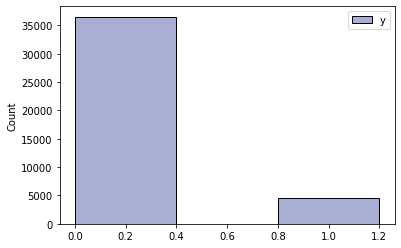

In [15]:
# Plot histogram of the label and calculate the imbalance in the dataset.
sns.histplot(df[['y']],binwidth=0.4,palette= 'BuPu')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


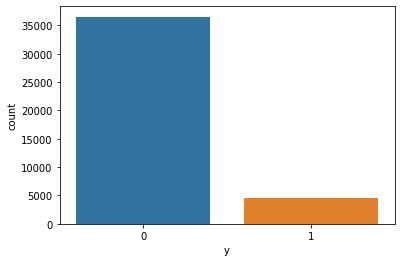

In [47]:
sns.countplot(df.y)

In [ ]:
# calculating the imbalance in the dataset
No = df['y'].value_counts()[0]/len(df.y)
yes = df['y'].value_counts()[1]/len(df.y)

print(" class No : %0.2f" % No)
print(" class Yes : %0.2f" % yes)

 class No : 0.89
 class Yes : 0.11


In [ ]:
# This is a severely imbalanced dataset 89% of the data is in class 'No', whereas only 11% of data is in class 'yes'

**Let's model the data:**

In [17]:
# separate your dataset into a training and a test set, with a test size of 20% and random_state=50.
y = df['y']
X = df.drop(columns='y')
train_x, valid_x, train_y, valid_y = train_test_split(X,y,test_size=0.20, random_state=50,stratify=y)

print(f"Total number of Training samples: {train_x.shape[0]} \n Total number of test samples :  {valid_x.shape[0]}")

Total number of Training samples: 32950 
 Total number of test samples :  8238


In [ ]:
# Make sure the train/test split is stratified (and check that it is!)

In [18]:
train_y.value_counts()/len(train_y)

0    0.887344
1    0.112656
Name: y, dtype: float64

In [19]:
valid_y.value_counts()/len(valid_y)

0    0.887351
1    0.112649
Name: y, dtype: float64

In [ ]:
# Both training and validation datasets have same percentage of class 0 and class 1 observations 

In [24]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

**RandomForestClassifier**

In [33]:
# Report the results of 10-fold stratified cross-validation on the training set using a random forest classifier with 100 trees and depth=3.
clf = RandomForestClassifier(n_estimators=100,max_depth=3)
scores = cross_val_score(clf,train_x,train_y,scoring='f1',cv=10)

print("f1: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))



f1: 0.23334221 +/- 0.02430113


In [69]:
#Perform 10-fold cross-validation using as a classifier a random forest with 300 estimators and a maximum depth of 6.
forest_clf = RandomForestClassifier(n_estimators=300,max_depth=6)
scores = cross_val_score(forest_clf,train_x,train_y,scoring='f1',cv=10)

print("f1: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))

f1: 0.28301704 +/- 0.04471647


In [74]:
#Report the generalisation error of a random forest classifier with 400 estimators and a maximum depth of 6. 
forest_clf = RandomForestClassifier(n_estimators=400,max_depth=6,random_state=60)
scores = cross_val_score(forest_clf,train_x,train_y,scoring='f1',cv=10)

print(f"f1:{scores.mean()}")

f1:0.28289199865770376


In [78]:
forest_clf.fit(train_x,train_y)
imp = forest_clf.feature_importances_

In [79]:
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_],axis=0)
indices = np.argsort(imp)[::-1]
print(indices)
features = X.columns
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  imp[indices[f]]))

[ 8  7  2 61  4  6  5  3  0 60 59 49 52 50 42 43 44 53 48  1 55 33 10 17
 34 14 31 45 56 57 23 27 51 46 47 58 22 28 54 18 38 36 16  9 30 39 41 32
 25 21 15 19 13 20 26 40 37 11 12 24 29 35]
Feature ranking:
1. nr.employed (0.169919)
2. euribor3m (0.149738)
3. pdays (0.115682)
4. poutcome_success (0.096064)
5. emp.var.rate (0.092905)
6. cons.conf.idx (0.078494)
7. cons.price.idx (0.056845)
8. previous (0.028729)
9. age (0.024708)
10. poutcome_nonexistent (0.021374)
11. poutcome_failure (0.018949)
12. month_mar (0.018282)
13. month_oct (0.015799)
14. month_may (0.014310)
15. contact_cellular (0.012540)
16. contact_telephone (0.011753)
17. month_apr (0.006585)
18. month_sep (0.006347)
19. month_jun (0.005000)
20. campaign (0.004507)
21. day_of_week_mon (0.003741)
22. default_no (0.003327)
23. job_blue-collar (0.003273)
24. job_student (0.003189)
25. default_unknown (0.003129)
26. job_retired (0.002874)
27. education_university.degree (0.002085)
28. month_aug (0.001694)
29. day_of_week_thu

**DummyClassifier**

In [36]:
dummy_clf = DummyClassifier(strategy="stratified") # always predicts the mean of the training set
dummy_scores = cross_val_score(dummy_clf, X, y, cv=10, scoring='f1')
print("f1: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))

f1: 0.11594973 +/- 0.01350305


Compare the results of your classifier with that of a dummy classifier.

**GridSearchCV to find a better set of parameters for your random forest.**

In [39]:
list(range(100,1000,100))

[100, 200, 300, 400, 500, 600, 700, 800, 900]

In [45]:
param_grid = {'n_estimators':range(100,1100,100),
              'criterion':['gini','entropy'],
              'max_depth' : range(2,10,1)
              }

search = GridSearchCV(clf,
                      param_grid=param_grid,
                      scoring='f1',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10),
                      verbose=2)


In [ ]:
search.best_score_

In [46]:
search.fit(train_x,train_y)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 89.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 132.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 155.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

0.32237120186875773

In [57]:
pred_y = search.predict(valid_x)


In [58]:
accuracy_score(valid_y,pred_y)

0.9009468317552805

In [59]:
search.best_estimator_.feature_importances_

array([0.03775198, 0.01292836, 0.09941545, 0.02539608, 0.0706008 ,
       0.05749345, 0.06156149, 0.14738877, 0.16051791, 0.00335672,
       0.00429464, 0.00123445, 0.00142956, 0.00189475, 0.00438996,
       0.0017555 , 0.00204582, 0.0040314 , 0.00309934, 0.00171797,
       0.00148346, 0.00201048, 0.00387207, 0.00407826, 0.00063432,
       0.00238249, 0.00186463, 0.00319968, 0.0036877 , 0.00020887,
       0.00330234, 0.00448128, 0.00227717, 0.00368767, 0.0038386 ,
       0.        , 0.00387647, 0.00148003, 0.00387128, 0.003444  ,
       0.00126449, 0.00315489, 0.01218201, 0.01238877, 0.00879369,
       0.00250839, 0.00158346, 0.00224502, 0.00568457, 0.01628004,
       0.01215493, 0.00217302, 0.01678738, 0.00445738, 0.00417431,
       0.00734643, 0.00418458, 0.00431829, 0.00376764, 0.0144844 ,
       0.01464536, 0.08943573])

In [64]:
classifier = RandomForestClassifier(          criterion='gini',
                                              max_depth=3,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              n_estimators=100)
classifier.fit(train_x,train_y)

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
features = X.columns
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

[ 8  7  6  2  4 61  5  3 49 52  0 60 43 42 50 53 59 44 17 14 34 46 10  1
 55 33 31 23 45 22 28 58 16 30 51 15 48 57 54 37 32 18 11 21 12 27 25  9
 20 19 39 13 38 56 36 26 35 40 29 41 47 24]
Feature ranking:
1. nr.employed (0.181377)
2. euribor3m (0.155945)
3. cons.conf.idx (0.106451)
4. pdays (0.105318)
5. emp.var.rate (0.089941)
6. poutcome_success (0.086015)
7. cons.price.idx (0.079310)
8. previous (0.049431)
9. month_mar (0.023463)
10. month_oct (0.019803)
11. age (0.017314)
12. poutcome_nonexistent (0.015815)
13. contact_telephone (0.015396)
14. contact_cellular (0.014517)
15. month_may (0.005324)
16. month_sep (0.005210)
17. poutcome_failure (0.004551)
18. month_apr (0.004148)
19. job_student (0.003651)
20. job_retired (0.002792)
21. default_unknown (0.002560)
22. month_dec (0.002192)
23. job_blue-collar (0.001797)
24. campaign (0.001532)
25. day_of_week_mon (0.000853)
26. default_no (0.000586)
27. education_university.degree (0.000493)
28. marital_single (0.000484)
29. month_aug 

In [66]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


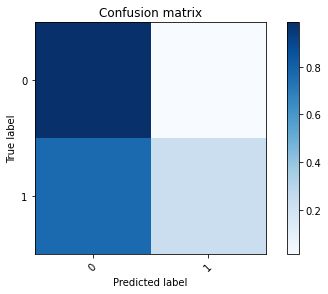

In [68]:
# Compute confusion matrix
import itertools
cnf_matrix = confusion_matrix(valid_y, pred_y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize=True,
                      title='Confusion matrix')

#plt.savefig("confusion.pdf", bbox_inches='tight')